In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from condition_prediction.run import ConditionPrediction
import wandb
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import gc

2024-02-15 18:34:04.848950: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-15 18:34:05.045881: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 18:34:05.046076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 18:34:05.080429: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 18:34:05.171618: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-15 18:34:05.173946: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
api = wandb.Api()
wandb_entity="ceb-sre"
wandb_project="orderly"

In [10]:
filter = {
    "config.output_folder_path": "models/no_trust_no_map"
}
ids = ["wwk85mpo", "6igi3f5x", "cw27b6c5", "2p28v0kz"]
runs = api.runs(f"{wandb_entity}/{wandb_project}", filters=filter)
for run in runs:
    if run.id in ids:
        run.config["dataset_version"] = "v6"
        run.update()

## Generate Table for dataset v6

In [5]:
DATASETS = ["with_trust_with_map","with_trust_no_map","no_trust_with_map", "no_trust_no_map", "with_trust_no_min_freq"]
lines = ["Solvents", "Agents", "Solvents \& Agents"]
top_n = 3
for dataset in DATASETS:
    filters = {
        "state": "finished",
        "config.output_folder_path": f"models/{dataset}",
        "config.random_seed": 12345,
        "config.train_fraction": 1.0,
        "config.train_mode": 0, # Teacher forcing
        "config.dataset_version": "v6"
    }
    runs = api.runs(
        f"{wandb_entity}/{wandb_project}",
        filters=filters
    )
    run = runs[0]
    if len(runs)>0:
        for r in runs:
            if run.config["dataset_version"] == "v5":
                run = r
                break

    # Get model solvent, agent and overall accuracy
    test_best = run.summary["test_best"]
    solvent_accuracy = test_best[f"solvent_accuracy_top{top_n}"]
    agent_accuracy = test_best[f"three_agents_accuracy_top{top_n}"]
    overall_accuracy = test_best[f"overall_accuracy_top{top_n}"]

    # Get frequency informed solvent, agent and overall accuracy
    fi_solvent_accuracy = run.summary[f"frequency_informed_solvent_accuracy_top_{top_n}"]
    fi_agent_accuracy = run.summary[f"frequency_informed_agent_accuracy_top_{top_n}"]
    fi_overall_accuracy = run.summary[f"frequency_informed_overall_accuracy_top_{top_n}"]

    # Improvement
    solvent_improvement = (solvent_accuracy-fi_solvent_accuracy)/(1-fi_solvent_accuracy)
    solvent_improvement_color = "lessgreen" if solvent_improvement>0 else "red"
    agent_improvement = (agent_accuracy-fi_agent_accuracy)/(1-fi_agent_accuracy)
    agent_improvement_color = "lessgreen" if agent_improvement>0 else "red"
    overall_improvement = (overall_accuracy-fi_overall_accuracy)/(1-fi_overall_accuracy)
    overall_improvement_color = "lessgreen" if overall_improvement>0 else "red"

    # Create table lines
    lines[0] += f" & {fi_solvent_accuracy*100:.0f} // {solvent_accuracy*100:.0f} // \\textcolor{{{solvent_improvement_color}}}{{{solvent_improvement*100:.0f}\%}} "
    lines[1] += f" & {fi_agent_accuracy*100:.0f} // {agent_accuracy*100:.0f} // \\textcolor{{{agent_improvement_color}}}{{{agent_improvement*100:.0f}\%}} "
    lines[2] += f" & {fi_overall_accuracy*100:.0f} // {overall_accuracy*100:.0f} // \\textcolor{{{overall_improvement_color}}}{{{overall_improvement*100:.0f}\%}} "
print("\\\\ \n".join(lines) + "\\\\")

Solvents & 57 // 70 // \textcolor{lessgreen}{31\%}  & 58 // 71 // \textcolor{lessgreen}{31\%}  & 36 // 51 // \textcolor{lessgreen}{24\%}  & 35 // 50 // \textcolor{lessgreen}{23\%}  & 57 // 70 // \textcolor{lessgreen}{30\%} \\ 
Agents & 91 // 94 // \textcolor{lessgreen}{26\%}  & 92 // 94 // \textcolor{lessgreen}{23\%}  & 46 // 56 // \textcolor{lessgreen}{20\%}  & 49 // 59 // \textcolor{lessgreen}{18\%}  & 91 // 93 // \textcolor{lessgreen}{22\%} \\ 
Solvents \& Agents & 52 // 67 // \textcolor{lessgreen}{32\%}  & 52 // 68 // \textcolor{lessgreen}{33\%}  & 20 // 35 // \textcolor{lessgreen}{19\%}  & 20 // 36 // \textcolor{lessgreen}{19\%}  & 51 // 66 // \textcolor{lessgreen}{32\%} \\


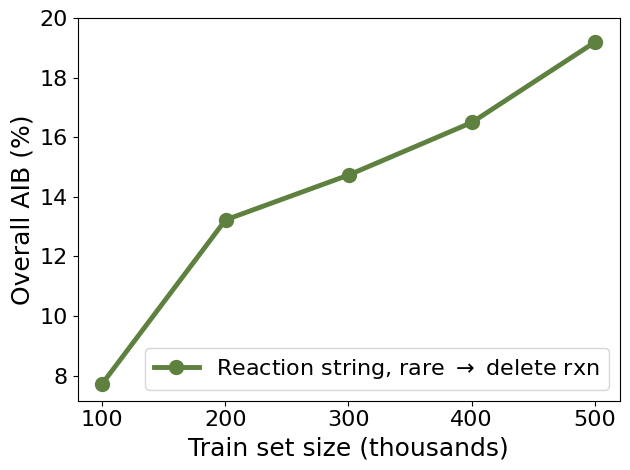

In [11]:
DATASETS = ["no_trust_no_map"]
LABELS = {
    "with_trust_with_map": r"Labelling, rare $\rightarrow$ other",
    "with_trust_no_map": r"Labelling, rare $\rightarrow$ delete rxn",
    "no_trust_with_map": r"Reaction string, rare $\rightarrow$ other",
    "no_trust_no_map": r"Reaction string, rare $\rightarrow$ delete rxn",
}
TRAIN_FRACS =  [0.2, 0.4, 0.6, 0.8, 1.0]
fig, ax = plt.subplots(1)
markers = ["o", "d", "s", "^"]
top_n = 3
colors = {
    "no_trust_with_map": "#5C4682",
    "no_trust_no_map": "#5e813f",
}
for i, dataset in enumerate(DATASETS):
    overall_accuracies = []
    n_train = []
    for train_fraction in TRAIN_FRACS:
        filters = {
            "state": "finished",
            "config.output_folder_path": f"models/{dataset}",
            # "config.random_seed": {"$in": [12345, 54321, 98765]},
            "config.random_seed": 12345,
            "config.train_fraction": train_fraction,
            "config.train_mode": 0, # Teacher forcing
            "config.dataset_version": {"$in": ["v6"]}
        }
        runs = api.runs(
            f"{wandb_entity}/{wandb_project}",
            filters=filters
        )
        run = runs[0]
        if len(runs)>0:
            for r in runs:
                if run.config["dataset_version"] == "v5":
                    run = r
                    break

        # Get overall accuracy
        acc_local = []
        for run in runs:
            overall_accuracy = run.summary[f"test_best"][f"overall_accuracy_top{top_n}"]
            fi_overall_accuracy = run.summary[f"frequency_informed_overall_accuracy_top_{top_n}"]
            overall_improvement = (overall_accuracy-fi_overall_accuracy)/(1-fi_overall_accuracy)
            acc_local.append(overall_improvement)
        overall_accuracies.append(np.mean(overall_improvement)*100)
        n_train.append(run.config["n_train"])
    
    # Add line to plot
    label = LABELS[dataset]
    ax.plot(
        # TRAIN_FRACS,
        np.array(n_train)/ 1e3, 
        overall_accuracies, 
        label=label, 
        linewidth=3.5, 
        marker=markers[i], 
        markersize=10,
        color=colors[dataset]
    )

# Formatting
axis_fontsize = 16
heading_fontsize = 18
ax.legend(loc="lower right", fontsize=axis_fontsize)
ax.set_xlabel("Train set size (thousands)", fontsize=heading_fontsize)
ax.set_ylabel("Overall AIB (%)",  fontsize=heading_fontsize)
# ax.set_xticks(TRAIN_FRACS)
# ax.set_xticklabels(ax.gefontsize=axis_fontsize)
ax.tick_params(labelsize=axis_fontsize)
# ax.ticklabel_format( style='sci',scilimits=(4,4))
ylabels = np.arange(8, 22, 2)
ax.set_yticks(ylabels)
ax.set_yticklabels([f"{ylabel:.0f}" for ylabel in ylabels], fontsize=axis_fontsize)
fig.tight_layout()
fig.savefig("scaling_behavior.png", dpi=300)

## Check intersection

In [57]:
# Get data
data_path = Path("/teamspace/studios/orderly-preprocessing/ORDerly/data/orderly/datasets_v6/")
no_trust_df = pd.read_parquet(data_path / "orderly_no_trust_no_map_test.parquet").reset_index(drop=True)
with_trust_df = pd.read_parquet(data_path / "orderly_with_trust_no_map_test.parquet").reset_index(drop=True)

# Get predictions
model_path = Path("/teamspace/studios/this_studio/ORDerly/models")
no_trust_predictions = pd.read_parquet(model_path / "no_trust_no_map/test_predictions.parquet")
no_trust_predictions = no_trust_predictions.rename(columns=lambda s: f"{s}_predict")
no_trust_df = pd.concat([no_trust_df, no_trust_predictions], axis=1)
with_trust_predictions = pd.read_parquet(model_path / "with_trust_no_map/test_predictions.parquet")
with_trust_predictions = with_trust_predictions.rename(columns=lambda s: f"{s}_predict")
with_trust_df = pd.concat([with_trust_df, with_trust_predictions], axis=1)

In [62]:
# Find intersection
idx_no_trust_original = no_trust_df["original_index"]
idx_with_trust_original = with_trust_df["original_index"]
common_idx_original = np.intersect1d(idx_1, idx_2)
print(f"Molecules in both datasets: {len(common_idx)}")
no_trust_selected = no_trust_df[no_trust_df["original_index"].isin(common_idx_original)]
with_trust_selected = with_trust_df[with_trust_df["original_index"].isin(common_idx_original)]

# Save
no_trust_selected.to_csv(model_path / "no_trust_no_map/no_trust_no_map_test_predictions_common.csv")
with_trust_selected.to_csv(model_path / "with_trust_no_map/with_trust_no_map_test_predictions_common.csv")

Molecules in both datasets: 1905
